In [289]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s5e3/sample_submission.csv
/kaggle/input/playground-series-s5e3/train.csv
/kaggle/input/playground-series-s5e3/test.csv
/kaggle/input/perfect-submision/perfect_submission.csv
/kaggle/input/dataset-scaled/test_scaled.csv
/kaggle/input/dataset-scaled/train_scaled.csv


In [290]:
# ============================================
#  BLOQUE 1: Preparación del Entorno
# ============================================

# ======1️⃣ Preparacion Ambiente======

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import xgboost as xgb
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

# Detectar dispositivo dinámicamente
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")
if torch.cuda.is_available():
    print("Nombre GPU:", torch.cuda.get_device_name(0))

# ====== 2️⃣ Funciones de Procesamiento ======

def drop_unnecessary_features(df, columns_to_drop=None, label_to_keep="rainfall"):
    if df is None or df.empty:
        raise ValueError("El DataFrame de entrada está vacío o es None.")

    if columns_to_drop is None:
        columns_to_drop = ['winddirection', 'maxtemp', 'mintemp']

    # Si 'rainfall' debe mantenerse, asegúrate de que no se elimine
    if label_to_keep == "rainfall" and "rainfall" in columns_to_drop:
        columns_to_drop.remove("rainfall")
        print("✅ 'rainfall' ha sido protegido de la eliminación.")

    # Se eliminan solo las columnas que existen en el DataFrame
    df = df.drop(columns=[col for col in columns_to_drop if col in df.columns], errors="ignore")

    return df.reset_index(drop=True)



Usando dispositivo: cpu


selected_features = [ 'rainfall',
    'temp_deviation',
    'pressure_acceleration',
    'windspeed_lag_1',
    'pressure_std_14d',
    'temp_std_14d',
    'windspeed_rolling_14d',
    'temp_range',
    'cloud',
    'maxtemp_diff1',
    'cloud_rolling_14d',
    'dewpoint_depression',
    'humidity_std_14d',
    'pressure_trend_3d',
    'humidity_std_7d',
    'cloud_rolling_7d',
    'cloud_sunshine_ratio',
    'windspeed_temp_interaction',
    'rain_prob_week',
    'sunshine',
    'cloud_sunshine_interaction',
    'humidity',
    'cloud_rolling_3d',
    'day_of_year_sin',
    'wind_humidity_factor',
    'humidity_dewpoint_ratio',
    'dewpoint_humidity_interaction',
    'dew_roll_std',
    'temp_humidity_interaction',
    'temperature_rolling_3d',
    'temperature_rolling_7d',
    'day_of_year_cos',
    'dew_roll_mean',
    'pressure_rolling_14d',
    'avg_temp',
    'temp_humidity_index',
    'pressure_temp_interaction',
    'temp_lag_1',
    'dewpoint'
]

In [291]:
selected_features = [ 'rainfall', 'temp_deviation', 'pressure_acceleration', 'windspeed_lag_1', 'pressure_std_14d', 'temp_std_14d', 'windspeed_rolling_14d', 'temp_range', 'cloud', 'maxtemp_diff1', 'cloud_rolling_14d', 'dewpoint_depression', 'humidity_std_14d', 'pressure_trend_3d', 'humidity_std_7d', 'cloud_rolling_7d', 'cloud_sunshine_ratio', 'windspeed_temp_interaction', 'rain_prob_week', 'sunshine', 'cloud_sunshine_interaction', 'humidity', 'cloud_rolling_3d', 'day_of_year_sin', 'wind_humidity_factor', 'humidity_dewpoint_ratio', 'dewpoint_humidity_interaction', 'dew_roll_std', 'temp_humidity_interaction', 'temperature_rolling_3d', 'temperature_rolling_7d', 'day_of_year_cos', 'dew_roll_mean', 'pressure_rolling_14d', 'avg_temp', 'temp_humidity_index', 'pressure_temp_interaction', 'temp_lag_1', 'dewpoint' ]

selected_features = [
    'dewpoint',
    'humidity',
    'cloud',
    'sunshine',
    'temp_deviation',
    'dewpoint_humidity_interaction',
    'cloud_rolling_3d',
    'pressure_std_14d',
    'day_of_year_cos',
    'temp_range']

In [292]:

# Cargar datos y procesar
df_train_scaled = pd.read_csv("/kaggle/input/dataset-scaled/train_scaled.csv")
df_test_scaled = pd.read_csv("/kaggle/input/dataset-scaled/test_scaled.csv")

# Mostrar primeras filas
display(df_train_scaled.head(3))

# Verificar que 'rainfall' sigue en el DataFrame original
if 'rainfall' not in df_train_scaled.columns:
    raise ValueError("La columna 'rainfall' no está en df_train. Verifica las columnas seleccionadas.")

# Obtener columnas a eliminar
columns_to_drop = [col for col in df_train_scaled.columns if col not in selected_features]

# Aplicar la función de eliminación de columnas
train_df = drop_unnecessary_features(df_train_scaled, columns_to_drop, label_to_keep="rainfall")
test_df = drop_unnecessary_features(df_test_scaled, columns_to_drop, label_to_keep="rainfall")

# Verificación después de la limpieza
#print("Columnas en test_df_final después de drop_unnecessary_features():", test_df_final.columns.tolist())

# Si 'rainfall' no está en test_df_final, simplemente copiamos los datos sin intentar eliminarla
X_test = test_df.copy()
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32).to(device)

# Depuración de train_df_final
#print("train_df_final preview:\n", display(train_df_final.head(3)))

# Verificar si la función devolvió un DataFrame
if train_df is None or test_df is None:
    raise ValueError("❌ La función drop_unnecessary_features() devolvió None. Verifica su implementación.")

# Verificar que 'rainfall' sigue en el DataFrame final
if 'rainfall' not in train_df.columns:
    raise ValueError("❌ La columna 'rainfall' ha sido eliminada accidentalmente.")

# Separar variables predictoras y variable objetivo
X = train_df.drop(columns=['rainfall'])
y = train_df['rainfall']

# División de datos (sin estratificación si 'y' es continua)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Mostrar formas de los conjuntos de datos
print("\nForma de X_train:", X_train.shape)
print("Forma de y_train:", y_train.shape)

# Mover a GPU (convertir a numpy antes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32).to(device)
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1).to(device)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).unsqueeze(1).to(device)

# Generar nombres de características si no están definidos
feature_names = X_train.columns.tolist()

print("Bloque 1 listo. Datos procesados correctamente.")

# Verificar si 'id' está en "test.csv" antes de extraer test_ids
df_test_id = pd.read_csv("/kaggle/input/playground-series-s5e3/test.csv")

if 'id' in df_test_id.columns:
    test_ids = df_test_id['id'].values
else:
    print("⚠️ Advertencia: 'id' no está en df_test. Se usará un índice como identificador.")
    test_ids = np.arange(len(X_test))



,day,pressure,temperature,dewpoint,humidity,cloud,sunshine,windspeed,cloud_sunshine_ratio,cloud_sunshine_interaction,...,rain_prob,cloud_diff_3v14,temp_diff_3v14,cloud_temp_interaction,humidity_pressure_diff,pressure_day_ratio,temp_minus_roll7,humidity_minus_roll7,season_transition,rainfall
0,1.0,0.516854,0.547718,0.729630,0.813559,0.877551,0.090909,0.232305,0.079820,0.110351,...,1.0,0.619922,0.529244,0.638744,0.686492,0.069982,0.620818,0.595122,0.517211,1
1,2.0,0.575843,0.394191,0.581481,0.949153,0.908163,0.000000,0.317604,0.909982,0.000000,...,1.0,0.619922,0.529244,0.566457,0.760480,0.069984,0.500465,0.663415,0.534402,1
2,3.0,0.705056,0.360996,0.355556,0.610169,0.459184,0.685950,0.248639,0.005468,0.444710,...,1.0,0.619922,0.529244,0.388164,0.579482,0.069989,0.505886,0.413008,0.551551,1



Forma de X_train: (1752, 38)
Forma de y_train: (1752,)
Bloque 1 listo. Datos procesados correctamente.


# Funcion Deep Learning NN para seleccion de features!

In [293]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, roc_auc_score

# 1️⃣ Modelo NN (sin sigmoid final)
class NN_modelo(nn.Module):
    def __init__(self, input_dim, hidden_dim1=128, hidden_dim2=64, dropout_rate=0.4):
        super(NN_modelo, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim1),
            nn.BatchNorm1d(hidden_dim1),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim1, hidden_dim2),
            nn.BatchNorm1d(hidden_dim2),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim2, 1)  # salida: logits
        )

    def forward(self, x):
        return self.model(x)

# 2️⃣ Entrenamiento y obtención de logits
def train_and_get_logits(X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor, 
                         feature_idx_list, hidden_dim=128, epochs=50, lr=0.0005, device='cpu'):
    
    X_train_subset = X_train_tensor[:, feature_idx_list]
    X_val_subset = X_val_tensor[:, feature_idx_list]

    model = NN_modelo(len(feature_idx_list), hidden_dim1=hidden_dim, hidden_dim2=hidden_dim//2).to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        output = model(X_train_subset)
        loss = criterion(output, y_train_tensor)
        loss.backward()
        optimizer.step()

    # Logits de validación
    model.eval()
    with torch.no_grad():
        logits_val = model(X_val_subset).cpu().numpy().flatten()
        y_val_np = y_val_tensor.cpu().numpy().flatten()

    return model, logits_val, y_val_np

# 3️⃣ Calibración con Platt Scaling (logistic)
def calibrate_logits_platt(logits_val, y_val_np, logits_test):
    calibrador = LogisticRegression(solver='lbfgs')
    calibrador.fit(logits_val.reshape(-1, 1), y_val_np)
    calibrated_probs_val = calibrador.predict_proba(logits_val.reshape(-1, 1))[:, 1]
    calibrated_probs_test = calibrador.predict_proba(logits_test.reshape(-1, 1))[:, 1]
    return calibrated_probs_val, calibrated_probs_test

# 4️⃣ Evaluación de métricas AUC + F1
def evaluate_predictions(y_true, y_probs):
    y_pred_binary = (y_probs >= 0.5).astype(int)
    auc = roc_auc_score(y_true, y_probs)
    f1 = f1_score(y_true, y_pred_binary)
    return auc, f1


In [294]:
# ====== 5️⃣ Entrenamiento Inicial con temp_range y cloud ======

# Features base
base_features = ['temp_range', 'cloud']

# Obtener índices de estas features en el orden de X_train
feature_idx_list = [feature_names.index(feat) for feat in base_features]

# Entrenamiento con logits
modelo_base, logits_val, y_val_np = train_and_get_logits(
    X_train_tensor, y_train_tensor,
    X_val_tensor, y_val_tensor,
    feature_idx_list=feature_idx_list,
    hidden_dim=128,
    epochs=50,
    lr=0.0005,
    device=device  # definido antes como 'cuda' o 'cpu'
)

# Logits del test para calibrar igual que validación
logits_test = modelo_base(X_test_tensor[:, feature_idx_list]).detach().cpu().numpy().flatten()

# Calibración con Platt Scaling
probs_val, probs_test = calibrate_logits_platt(logits_val, y_val_np, logits_test)

# Evaluación con métricas
auc_base, f1_base = evaluate_predictions(y_val_np, probs_val)

# Mostrar resultados
print(f"\n✅ Modelo base entrenado con {base_features}")
print(f"AUC: {auc_base:.4f} | F1: {f1_base:.4f}")




✅ Modelo base entrenado con ['temp_range', 'cloud']
AUC: 0.8495 | F1: 0.8992


Features seleccionadas: ['cloud', 'temp_range', 'dew_roll_mean', 'dewpoint_humidity_interaction', 'sunshine', 'temperature_rolling_7d']  
Features seleccionadas: ['cloud', 'temp_range', 'temperature_rolling_7d', 'pressure_trend_3d', 'cloud_rolling_7d']  
Features seleccionadas: ['cloud', 'temp_range', 'windspeed_lag_1', 'humidity_dewpoint_ratio', 'dew_roll_mean']  
Features seleccionadas: ['cloud', 'temp_range', 'windspeed_temp_interaction', 'cloud_rolling_7d', 'sunshine', 'dew_roll_mean'  
Features seleccionadas: ['cloud', 'temp_range', 'pressure_std_14d', 'cloud_rolling_3d', 'pressure_acceleration', 'cloud_sunshine_interaction', 'avg_temp', 'temperature_rolling_3d', 'windspeed_temp_interaction', 'temp_deviation', 'temp_humidity_index', 'pressure_temp_interaction']


In [295]:
import numpy as np
import pandas as pd

def evaluar_features_con_repeats(X_train_tensor, y_train_tensor,
                                 X_val_tensor, y_val_tensor,
                                 X_test_tensor,
                                 feature_names, base_features,
                                 train_and_get_logits_fn,
                                 calibrate_logits_platt_fn,
                                 evaluate_predictions_fn,
                                 device='cpu', hidden_dim=128, 
                                 epochs=50, lr=0.0005, n_repeats=3):
    
    base_idx = [feature_names.index(f) for f in base_features]

    # Entrenamiento base
    modelo_base, logits_base, y_val_np_base = train_and_get_logits_fn(
        X_train_tensor, y_train_tensor,
        X_val_tensor, y_val_tensor,
        feature_idx_list=base_idx,
        hidden_dim=hidden_dim,
        epochs=epochs,
        lr=lr,
        device=device
    )

    logits_test_base = modelo_base(X_test_tensor[:, base_idx]).detach().cpu().numpy().flatten()
    probs_val_base, _ = calibrate_logits_platt_fn(logits_base, y_val_np_base, logits_test_base)
    auc_base, f1_base = evaluate_predictions_fn(y_val_np_base, probs_val_base)
    base_score = (auc_base + f1_base) / 2

    feature_contributions = []
    candidates = [f for f in feature_names if f not in base_features]

    print("\n🔍 Evaluando el aporte individual de cada feature al modelo base con repetición...")

    for feat in candidates:
        feature_idx_list_temp = [feature_names.index(f) for f in base_features + [feat]]

        aucs, f1s, scores = [], [], []

        for _ in range(n_repeats):
            modelo_temp, logits_val, y_val_np = train_and_get_logits_fn(
                X_train_tensor, y_train_tensor,
                X_val_tensor, y_val_tensor,
                feature_idx_list=feature_idx_list_temp,
                hidden_dim=hidden_dim,
                epochs=epochs,
                lr=lr,
                device=device
            )
            logits_test = modelo_temp(X_test_tensor[:, feature_idx_list_temp]).detach().cpu().numpy().flatten()
            probs_val, _ = calibrate_logits_platt_fn(logits_val, y_val_np, logits_test)
            auc, f1 = evaluate_predictions_fn(y_val_np, probs_val)
            aucs.append(auc)
            f1s.append(f1)
            scores.append((auc + f1) / 2)

        auc_mean = np.mean(aucs)
        f1_mean = np.mean(f1s)
        score_mean = np.mean(scores)
        score_std = np.std(scores)
        gain = score_mean - base_score

        print(f"✅ '{feat}' evaluada | Score: {score_mean:.4f} ± {score_std:.4f} | Ganancia: {gain:+.4f}")

        feature_contributions.append({
            "feature": feat,
            "auc": auc_mean,
            "f1": f1_mean,
            "score": score_mean,
            "std_score": score_std,
            "gain_vs_base": gain
        })

    contrib_df = pd.DataFrame(feature_contributions).sort_values(by="gain_vs_base", ascending=False).reset_index(drop=True)

    print("\n🏁 Evaluación finalizada. Ranking de aporte de features:")
    display(contrib_df)

    return contrib_df


# 🔧 Llamada principal
contrib_df = evaluar_features_con_repeats(
    X_train_tensor, y_train_tensor,
    X_val_tensor, y_val_tensor,
    X_test_tensor,
    feature_names=feature_names,
    base_features=['temp_range', 'cloud'],
    train_and_get_logits_fn=train_and_get_logits,
    calibrate_logits_platt_fn=calibrate_logits_platt,
    evaluate_predictions_fn=evaluate_predictions,
    device=device,
    hidden_dim=128,
    epochs=50,
    lr=0.0005,
    n_repeats=3
)



🔍 Evaluando el aporte individual de cada feature al modelo base con repetición...
✅ 'dewpoint' evaluada | Score: 0.8771 ± 0.0004 | Ganancia: +0.0018
✅ 'humidity' evaluada | Score: 0.8805 ± 0.0011 | Ganancia: +0.0052
✅ 'sunshine' evaluada | Score: 0.8747 ± 0.0011 | Ganancia: -0.0006
✅ 'cloud_sunshine_ratio' evaluada | Score: 0.8724 ± 0.0007 | Ganancia: -0.0029
✅ 'cloud_sunshine_interaction' evaluada | Score: 0.8739 ± 0.0006 | Ganancia: -0.0014
✅ 'avg_temp' evaluada | Score: 0.8782 ± 0.0009 | Ganancia: +0.0029
✅ 'temp_deviation' evaluada | Score: 0.8740 ± 0.0009 | Ganancia: -0.0012
✅ 'dewpoint_depression' evaluada | Score: 0.8790 ± 0.0014 | Ganancia: +0.0037
✅ 'dewpoint_humidity_interaction' evaluada | Score: 0.8838 ± 0.0018 | Ganancia: +0.0085
✅ 'dew_roll_mean' evaluada | Score: 0.8806 ± 0.0002 | Ganancia: +0.0053
✅ 'dew_roll_std' evaluada | Score: 0.8754 ± 0.0011 | Ganancia: +0.0002
✅ 'pressure_acceleration' evaluada | Score: 0.8743 ± 0.0017 | Ganancia: -0.0009
✅ 'pressure_trend_3d' e

,feature,auc,f1,score,std_score,gain_vs_base
0,dewpoint_humidity_interaction,0.866793,0.900807,0.883800,0.001836,0.008535
1,rain_prob_week,0.866828,0.898346,0.882587,0.000309,0.007322
2,dew_roll_mean,0.859066,0.902058,0.880562,0.000191,0.005297
3,humidity,0.865296,0.895690,0.880493,0.001062,0.005228
4,temp_humidity_interaction,0.863105,0.897552,0.880329,0.000443,0.005064
5,dewpoint_depression,0.856379,0.901541,0.878960,0.001402,0.003695
6,pressure_trend_3d,0.857678,0.899752,0.878715,0.000742,0.003450
7,avg_temp,0.857011,0.899350,0.878181,0.000905,0.002916
8,temperature_rolling_7d,0.856414,0.899109,0.877761,0.001883,0.002496
9,temp_humidity_index,0.858135,0.897140,0.877637,0.000438,0.002373


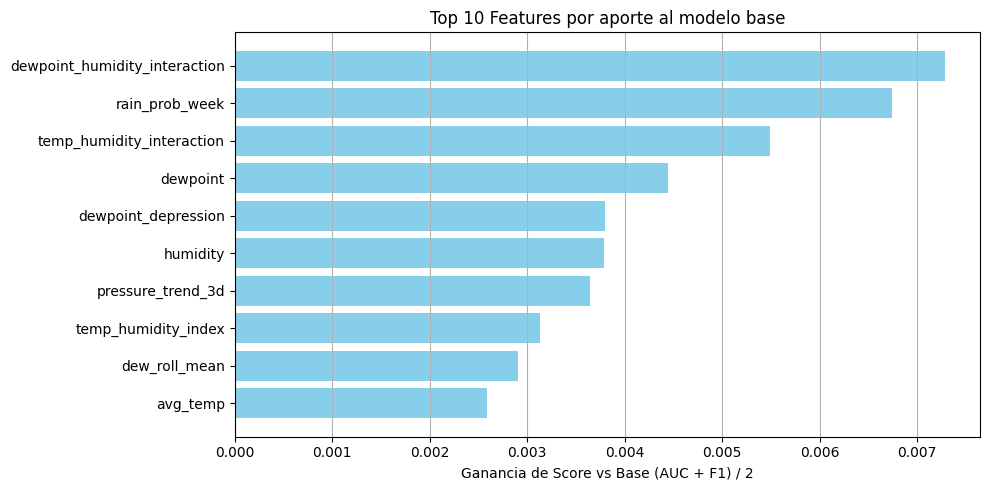

In [296]:
# ====== 📈 Gráfico de los Top 10 features por ganancia ======

TOP_N = 10
top_features = contrib_df_sorted.head(TOP_N)

plt.figure(figsize=(10, 5))
plt.barh(top_features['feature'][::-1], top_features['gain_vs_base'][::-1], color='skyblue')
plt.xlabel("Ganancia de Score vs Base (AUC + F1) / 2")
plt.title(f"Top {TOP_N} Features por aporte al modelo base")
plt.grid(axis='x')
plt.tight_layout()
plt.show()

In [297]:
contrib_df_sorted.to_csv("feature_contributions.csv", index=False)

🏁 Modelo base con ['temp_range', 'cloud'] | AUC: 0.8153 | F1: 0.8869 | Score: 0.8511
🔍 'dewpoint' | AUC: 0.8350, F1: 0.8929, Score: 0.8639, Ganancia: +0.0128
🔍 'humidity' | AUC: 0.8216, F1: 0.8783, Score: 0.8500, Ganancia: -0.0012
🔍 'sunshine' | AUC: 0.8322, F1: 0.8872, Score: 0.8597, Ganancia: +0.0086
🔍 'cloud_sunshine_ratio' | AUC: 0.8179, F1: 0.8889, Score: 0.8534, Ganancia: +0.0023
🔍 'cloud_sunshine_interaction' | AUC: 0.8205, F1: 0.8945, Score: 0.8575, Ganancia: +0.0064
🔍 'avg_temp' | AUC: 0.8222, F1: 0.8776, Score: 0.8499, Ganancia: -0.0012
🔍 'temp_deviation' | AUC: 0.8277, F1: 0.8992, Score: 0.8635, Ganancia: +0.0123
🔍 'dewpoint_depression' | AUC: 0.8379, F1: 0.8929, Score: 0.8654, Ganancia: +0.0142
🔍 'dewpoint_humidity_interaction' | AUC: 0.8429, F1: 0.8985, Score: 0.8707, Ganancia: +0.0196
🔍 'dew_roll_mean' | AUC: 0.8340, F1: 0.8912, Score: 0.8626, Ganancia: +0.0115
🔍 'dew_roll_std' | AUC: 0.8289, F1: 0.8886, Score: 0.8587, Ganancia: +0.0076
🔍 'pressure_acceleration' | AUC: 0.

,feature,auc,f1,score,gain_vs_base
0,dewpoint_humidity_interaction,0.842918,0.898507,0.870713,0.019585
1,dewpoint_depression,0.837886,0.892857,0.865372,0.014244
2,dewpoint,0.835041,0.892857,0.863949,0.012822
3,temp_deviation,0.827705,0.899248,0.863476,0.012349
4,dew_roll_mean,0.833961,0.891207,0.862584,0.011457
5,day_of_year_cos,0.821843,0.900741,0.861292,0.010165
6,pressure_temp_interaction,0.828218,0.892857,0.860538,0.009410
7,sunshine,0.832209,0.887240,0.859725,0.008598
8,humidity_dewpoint_ratio,0.837043,0.881559,0.859301,0.008174
9,dew_roll_std,0.828930,0.888554,0.858742,0.007615


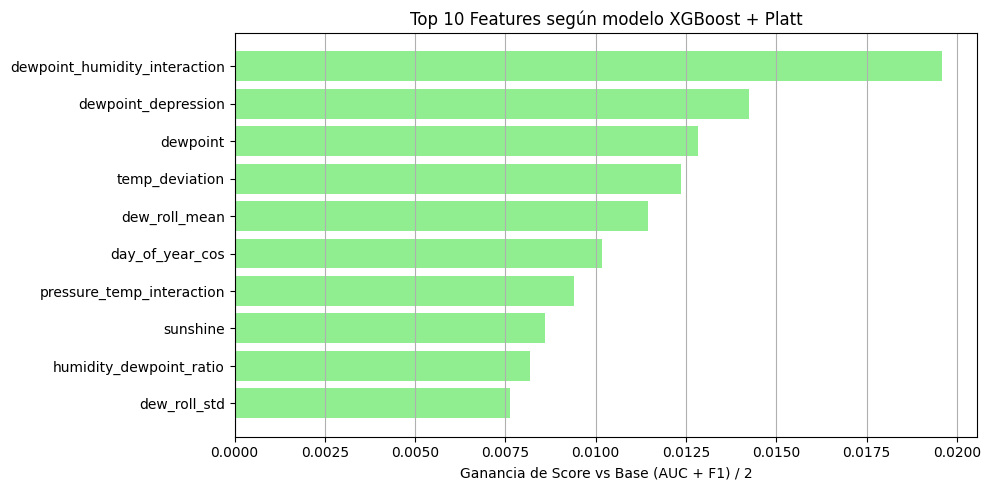

In [298]:
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt

# =========================
# Configuración Inicial
# =========================
base_features = ['temp_range', 'cloud']
candidates = [f for f in feature_names if f not in base_features]

# Dataset base
X_base = X_train[base_features]
X_val_base = X_val[base_features]

# Entrenamiento modelo base (logits)
xgb_base = XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='logloss', verbosity=0)
xgb_base.fit(X_base, y_train)
logits_val_base = xgb_base.predict(X_val_base, output_margin=True)

# Calibración Platt sobre logits
cal_platt = LogisticRegression(solver='lbfgs')
cal_platt.fit(logits_val_base.reshape(-1, 1), y_val)
y_prob_val_base = cal_platt.predict_proba(logits_val_base.reshape(-1, 1))[:, 1]
y_bin_val_base = (y_prob_val_base >= 0.5).astype(int)

# Métricas base calibradas
auc_base = roc_auc_score(y_val, y_prob_val_base)
f1_base = f1_score(y_val, y_bin_val_base)
score_base = (auc_base + f1_base) / 2

print(f"🏁 Modelo base con {base_features} | AUC: {auc_base:.4f} | F1: {f1_base:.4f} | Score: {score_base:.4f}")

# =========================
# Evaluación de candidatos
# =========================
contribuciones = []

for feat in candidates:
    X_temp = X_train[base_features + [feat]]
    X_val_temp = X_val[base_features + [feat]]
    
    xgb_temp = XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='logloss', verbosity=0)
    xgb_temp.fit(X_temp, y_train)
    logits_val = xgb_temp.predict(X_val_temp, output_margin=True)

    # Calibración Platt
    cal_platt = LogisticRegression(solver='lbfgs')
    cal_platt.fit(logits_val.reshape(-1, 1), y_val)
    y_prob_val = cal_platt.predict_proba(logits_val.reshape(-1, 1))[:, 1]
    y_bin_val = (y_prob_val >= 0.5).astype(int)

    # Métricas calibradas
    auc = roc_auc_score(y_val, y_prob_val)
    f1 = f1_score(y_val, y_bin_val)
    score = (auc + f1) / 2
    gain = score - score_base

    contribuciones.append({
        "feature": feat,
        "auc": auc,
        "f1": f1,
        "score": score,
        "gain_vs_base": gain
    })
    
    print(f"🔍 '{feat}' | AUC: {auc:.4f}, F1: {f1:.4f}, Score: {score:.4f}, Ganancia: {gain:+.4f}")

# =========================
# Ranking y Gráfico Final
# =========================

contrib_df = pd.DataFrame(contribuciones)
contrib_df_sorted = contrib_df.sort_values(by="gain_vs_base", ascending=False).reset_index(drop=True)

print("\n📊 Ranking de features por ganancia sobre modelo base (XGBoost + Platt):")
display(contrib_df_sorted)

# Gráfico de los Top 10
TOP_N = 10
top_features = contrib_df_sorted.head(TOP_N)

plt.figure(figsize=(10, 5))
plt.barh(top_features['feature'][::-1], top_features['gain_vs_base'][::-1], color='lightgreen')
plt.xlabel("Ganancia de Score vs Base (AUC + F1) / 2")
plt.title(f"Top {TOP_N} Features según modelo XGBoost + Platt")
plt.grid(axis='x')
plt.tight_layout()
plt.show()


🏁 Modelo base con ['temp_range', 'cloud'] | AUC: 0.8511 | F1: 0.8999 | Score: 0.8755
🔍 'dewpoint' | AUC: 0.8607, F1: 0.8991, Score: 0.8799, Ganancia: +0.0045
🔍 'humidity' | AUC: 0.8650, F1: 0.8936, Score: 0.8793, Ganancia: +0.0038
🔍 'sunshine' | AUC: 0.8506, F1: 0.8999, Score: 0.8752, Ganancia: -0.0002
🔍 'cloud_sunshine_ratio' | AUC: 0.8490, F1: 0.8999, Score: 0.8744, Ganancia: -0.0011
🔍 'cloud_sunshine_interaction' | AUC: 0.8510, F1: 0.8999, Score: 0.8754, Ganancia: -0.0000
🔍 'avg_temp' | AUC: 0.8573, F1: 0.8988, Score: 0.8781, Ganancia: +0.0026
🔍 'temp_deviation' | AUC: 0.8480, F1: 0.8999, Score: 0.8739, Ganancia: -0.0015
🔍 'dewpoint_depression' | AUC: 0.8584, F1: 0.9001, Score: 0.8793, Ganancia: +0.0038
🔍 'dewpoint_humidity_interaction' | AUC: 0.8664, F1: 0.8991, Score: 0.8827, Ganancia: +0.0073
🔍 'dew_roll_mean' | AUC: 0.8582, F1: 0.8985, Score: 0.8784, Ganancia: +0.0029
🔍 'dew_roll_std' | AUC: 0.8488, F1: 0.8972, Score: 0.8730, Ganancia: -0.0025
🔍 'pressure_acceleration' | AUC: 0.

,feature,auc,f1,score,gain_vs_base
0,dewpoint_humidity_interaction,0.866389,0.899110,0.882749,0.007282
1,rain_prob_week,0.864282,0.900149,0.882215,0.006748
2,temp_humidity_interaction,0.862807,0.899110,0.880958,0.005491
3,dewpoint,0.860725,0.899110,0.879918,0.004450
4,dewpoint_depression,0.858381,0.900149,0.879265,0.003798
5,humidity,0.864954,0.893553,0.879253,0.003786
6,pressure_trend_3d,0.855378,0.902840,0.879109,0.003642
7,temp_humidity_index,0.859724,0.897474,0.878599,0.003132
8,dew_roll_mean,0.858249,0.898507,0.878378,0.002911
9,avg_temp,0.857301,0.898810,0.878055,0.002588


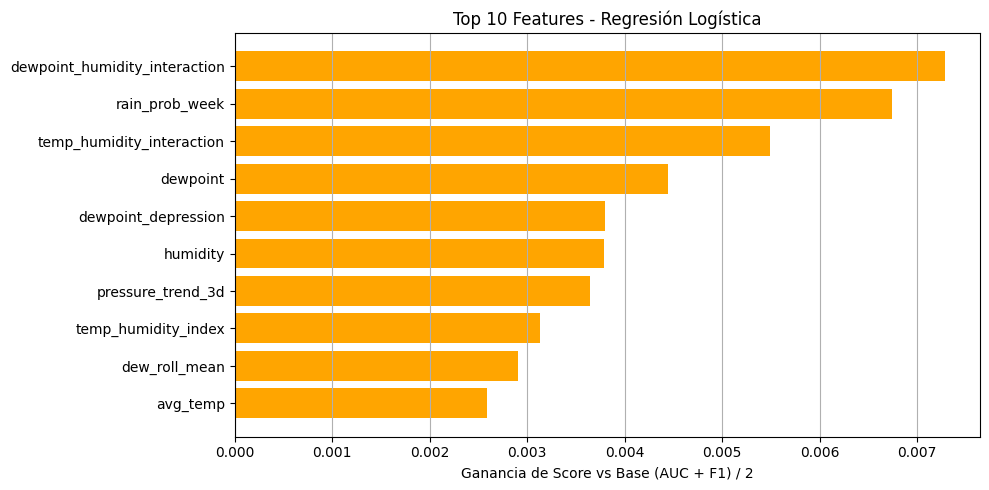

In [299]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.preprocessing import StandardScaler
import pandas as pd
import matplotlib.pyplot as plt

# =========================
# Configuración Inicial
# =========================

base_features = ['temp_range', 'cloud']
candidates = [f for f in feature_names if f not in base_features]

# Escalar datos (regresión logística lo requiere)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Convertir a DataFrame para mantener columnas
X_train_df = pd.DataFrame(X_train_scaled, columns=feature_names)
X_val_df = pd.DataFrame(X_val_scaled, columns=feature_names)

# Dataset base
X_base = X_train_df[base_features]
X_val_base = X_val_df[base_features]

# Entrenamiento modelo base
lr_base = LogisticRegression(max_iter=1000)
lr_base.fit(X_base, y_train)
y_pred_proba_base = lr_base.predict_proba(X_val_base)[:, 1]
y_pred_bin_base = (y_pred_proba_base >= 0.5).astype(int)

# Métricas base
auc_base = roc_auc_score(y_val, y_pred_proba_base)
f1_base = f1_score(y_val, y_pred_bin_base)
score_base = (auc_base + f1_base) / 2

print(f"🏁 Modelo base con {base_features} | AUC: {auc_base:.4f} | F1: {f1_base:.4f} | Score: {score_base:.4f}")

# =========================
# Evaluación de candidatos
# =========================

contribuciones = []

for feat in candidates:
    X_temp = X_train_df[base_features + [feat]]
    X_val_temp = X_val_df[base_features + [feat]]

    lr_temp = LogisticRegression(max_iter=1000)
    lr_temp.fit(X_temp, y_train)
    y_pred_proba_temp = lr_temp.predict_proba(X_val_temp)[:, 1]
    y_pred_bin_temp = (y_pred_proba_temp >= 0.5).astype(int)

    auc = roc_auc_score(y_val, y_pred_proba_temp)
    f1 = f1_score(y_val, y_pred_bin_temp)
    score = (auc + f1) / 2
    gain = score - score_base

    contribuciones.append({
        "feature": feat,
        "auc": auc,
        "f1": f1,
        "score": score,
        "gain_vs_base": gain
    })

    print(f"🔍 '{feat}' | AUC: {auc:.4f}, F1: {f1:.4f}, Score: {score:.4f}, Ganancia: {gain:+.4f}")

# =========================
# Ranking y Gráfico Final
# =========================

contrib_df = pd.DataFrame(contribuciones)
contrib_df_sorted = contrib_df.sort_values(by="gain_vs_base", ascending=False).reset_index(drop=True)

print("\n📊 Ranking de features por ganancia sobre modelo base (Regresión Logística):")
display(contrib_df_sorted)

# Gráfico de los Top 10
TOP_N = 10
top_features = contrib_df_sorted.head(TOP_N)

plt.figure(figsize=(10, 5))
plt.barh(top_features['feature'][::-1], top_features['gain_vs_base'][::-1], color='orange')
plt.xlabel("Ganancia de Score vs Base (AUC + F1) / 2")
plt.title(f"Top {TOP_N} Features - Regresión Logística")
plt.grid(axis='x')
plt.tight_layout()
plt.show()


In [300]:
final_features = [
    'dewpoint_humidity_interaction',
    'rain_prob_week',
    'temp_humidity_interaction',
    'dewpoint',
    'dewpoint_depression',
    'pressure_temp_interaction',
    'dew_roll_mean',
    'humidity',
    'avg_temp',
    'temp_humidity_index',
    'pressure_trend_3d',
    'day_of_year_cos',
    'temperature_rolling_7d']

# Versión sin Sigmoid del modelo NN

In [301]:
base_features = ['temp_range', 'cloud']

optimal = [
    'dewpoint_humidity_interaction',
    'rain_prob_week',
    'temp_humidity_interaction',
    'dewpoint',
    'dewpoint_depression',
    'pressure_temp_interaction',
    'humidity',
    'temp_humidity_index',
    'pressure_trend_3d',
]

final_features = base_features  + optimal 
final_features

['temp_range',
 'cloud',
 'dewpoint_humidity_interaction',
 'rain_prob_week',
 'temp_humidity_interaction',
 'dewpoint',
 'dewpoint_depression',
 'pressure_temp_interaction',
 'humidity',
 'temp_humidity_index',
 'pressure_trend_3d']

In [302]:
def evaluar_incremental_nn(X_train_tensor, y_train_tensor,
                           X_val_tensor, y_val_tensor,
                           X_test_tensor,
                           feature_names, final_features,
                           train_and_get_logits_fn,
                           calibrate_logits_platt_fn,
                           evaluate_predictions_fn,
                           device='cpu',
                           hidden_dim=128,
                           epochs=50,
                           lr=0.0005,
                           n_repeats=3):
    
    resultados = []

    for k in range(1, len(final_features) + 1):
        feats = final_features[:k]
        idx_list = [feature_names.index(f) for f in feats]

        aucs, f1s, scores = [], [], []

        for _ in range(n_repeats):
            # Entrenar modelo y obtener logits
            model, logits_val, y_val_np = train_and_get_logits_fn(
                X_train_tensor, y_train_tensor,
                X_val_tensor, y_val_tensor,
                feature_idx_list=idx_list,
                hidden_dim=hidden_dim,
                epochs=epochs,
                lr=lr,
                device=device
            )

            # Obtener logits del test para calibrar igual que en validación
            logits_test = model(X_test_tensor[:, idx_list]).detach().cpu().numpy().flatten()

            # Calibrar
            probs_val, _ = calibrate_logits_platt_fn(logits_val, y_val_np, logits_test)

            # Evaluar
            auc, f1 = evaluate_predictions_fn(y_val_np, probs_val)
            aucs.append(auc)
            f1s.append(f1)
            scores.append((auc + f1) / 2)

        # Guardar resultados
        resultados.append({
            "num_features": k,
            "features": feats,
            "auc_mean": np.mean(aucs),
            "f1_mean": np.mean(f1s),
            "score_mean": np.mean(scores),
            "score_std": np.std(scores)
        })

        print(f"✅ {k} features | AUC: {np.mean(aucs):.4f} | F1: {np.mean(f1s):.4f} | Score: {np.mean(scores):.4f} ± {np.std(scores):.4f}")

    return pd.DataFrame(resultados)


df_resultados = evaluar_incremental_nn(
    X_train_tensor, y_train_tensor,
    X_val_tensor, y_val_tensor,
    X_test_tensor,
    feature_names, final_features,
    train_and_get_logits_fn=train_and_get_logits,
    calibrate_logits_platt_fn=calibrate_logits_platt,
    evaluate_predictions_fn=evaluate_predictions,
    device=device,
    hidden_dim=128,
    epochs=50,
    lr=0.0005,
    n_repeats=3
)

✅ 1 features | AUC: 0.6125 | F1: 0.8432 | Score: 0.7278 ± 0.0018
✅ 2 features | AUC: 0.8499 | F1: 0.8988 | Score: 0.8744 ± 0.0006
✅ 3 features | AUC: 0.8643 | F1: 0.8999 | Score: 0.8821 ± 0.0011
✅ 4 features | AUC: 0.8754 | F1: 0.9019 | Score: 0.8886 ± 0.0010
✅ 5 features | AUC: 0.8766 | F1: 0.9045 | Score: 0.8905 ± 0.0012
✅ 6 features | AUC: 0.8736 | F1: 0.9019 | Score: 0.8878 ± 0.0006
✅ 7 features | AUC: 0.8773 | F1: 0.9027 | Score: 0.8900 ± 0.0004
✅ 8 features | AUC: 0.8785 | F1: 0.9009 | Score: 0.8897 ± 0.0019
✅ 9 features | AUC: 0.8801 | F1: 0.8960 | Score: 0.8881 ± 0.0019
✅ 10 features | AUC: 0.8786 | F1: 0.9004 | Score: 0.8895 ± 0.0016
✅ 11 features | AUC: 0.8793 | F1: 0.8975 | Score: 0.8884 ± 0.0018


In [303]:
# modulo_nn_simple.py

import pandas as pd

def entrenar_y_guardar_nn(
    X_train_tensor, y_train_tensor,
    X_val_tensor, y_val_tensor,
    X_test_tensor,
    feature_names, final_features,
    train_and_get_logits,
    calibrate_logits_platt,
    evaluate_predictions,
    device='cpu'
):
    idx = [feature_names.index(f) for f in final_features]

    modelo, logits_val, y_val_np = train_and_get_logits(
        X_train_tensor, y_train_tensor,
        X_val_tensor, y_val_tensor,
        feature_idx_list=idx,
        hidden_dim=128,
        epochs=50,
        lr=0.0005,
        device=device
    )

    logits_test = modelo(X_test_tensor[:, idx]).detach().cpu().numpy().flatten()
    probs_val, probs_test = calibrate_logits_platt(logits_val, y_val_np, logits_test)
    auc, f1 = evaluate_predictions(y_val_np, probs_val)

    print(f'\n✅ AUC: {auc:.4f} | F1: {f1:.4f}')

    pd.DataFrame({'pred_nn': probs_val, 'y_true': y_val_np}).to_csv('nn_val.csv', index=False)
    pd.DataFrame({'pred_nn': probs_test}).to_csv('nn_test.csv', index=False)

    return modelo

modelo_NN = entrenar_y_guardar_nn(
    X_train_tensor, y_train_tensor,
    X_val_tensor, y_val_tensor,
    X_test_tensor,
    feature_names, final_features,
    train_and_get_logits,
    calibrate_logits_platt,
    evaluate_predictions,
    device='cpu'
)
probs_val_nn = probs_val


✅ AUC: 0.8802 | F1: 0.8959


In [304]:
feature_idx_list = [feature_names.index(feat) for feat in final_features]

modelo_base, logits_val, y_val_np = train_and_get_logits(
    X_train_tensor, y_train_tensor,
    X_val_tensor, y_val_tensor,
    feature_idx_list=feature_idx_list,
    hidden_dim=128,
    epochs=50,
    lr=0.0005,
    device=device  # 'cuda' o 'cpu'
)


logits_test_nn = modelo_base(X_test_tensor[:, feature_idx_list]).detach().cpu().numpy().flatten()

calibrador_nn = LogisticRegression(solver='lbfgs', max_iter=1000)
calibrador_nn.fit(logits_val.reshape(-1, 1), y_val_np)

# Guardar todo el modelo entrenado y calibrado
model_NN = {
    'modelo': modelo_base,
    'calibrador': calibrador_nn,
    'features': final_features,
    'feature_idx_list': feature_idx_list}

logits_test_nn = model_NN['modelo'](X_test_tensor[:, model_NN['feature_idx_list']])
logits_test_nn = logits_test_nn.detach().cpu().numpy().flatten()
probs_test_nn = model_NN['calibrador'].predict_proba(logits_test_nn.reshape(-1, 1))[:, 1]

In [305]:
base_features = ['temp_range', 'cloud']
final_features = base_features + [
    'dewpoint_humidity_interaction',
    'rain_prob_week',
    'temp_humidity_interaction',
    'dewpoint',
    'dew_roll_mean',
    'humidity',
    'avg_temp',
    'temp_humidity_index',
    'pressure_trend_3d',
    'day_of_year_cos',
    'dewpoint_depression'
]

def evaluar_incremental_xgb(X_train, y_train, X_val, y_val, final_features, n_repeats=3):
    resultados = []

    for k in range(1, len(final_features) + 1):
        feats = final_features[:k]
        aucs, f1s, scores = [], [], []

        for _ in range(n_repeats):
            xgb_model = XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='logloss', verbosity=0)
            xgb_model.fit(X_train[feats], y_train)

            logits_val = xgb_model.predict_proba(X_val[feats])[:, 1]

            calibrador = LogisticRegression(solver='lbfgs', max_iter=1000)
            calibrador.fit(logits_val.reshape(-1, 1), y_val)
            probs_val = calibrador.predict_proba(logits_val.reshape(-1, 1))[:, 1]

            auc = roc_auc_score(y_val, probs_val)
            f1 = f1_score(y_val, (probs_val >= 0.5).astype(int))
            score = (auc + f1) / 2

            aucs.append(auc)
            f1s.append(f1)
            scores.append(score)

        resultados.append({
            "num_features": k,
            "features": feats,
            "auc_mean": np.mean(aucs),
            "f1_mean": np.mean(f1s),
            "score_mean": np.mean(scores),
            "score_std": np.std(scores)
        })

        print(f"✅ {k} features | AUC: {np.mean(aucs):.4f} | F1: {np.mean(f1s):.4f} | Score: {np.mean(scores):.4f} ± {np.std(scores):.4f}")

    return pd.DataFrame(resultados)

# Ejecutar selección incremental
print("XGB Model Feature Selection")
df_resultados_xgb = evaluar_incremental_xgb(X_train, y_train, X_val, y_val, final_features, n_repeats=3)

XGB Model Feature Selection
✅ 1 features | AUC: 0.6045 | F1: 0.8428 | Score: 0.7237 ± 0.0000
✅ 2 features | AUC: 0.8153 | F1: 0.8882 | Score: 0.8518 ± 0.0000
✅ 3 features | AUC: 0.8429 | F1: 0.8985 | Score: 0.8707 ± 0.0000
✅ 4 features | AUC: 0.8507 | F1: 0.9031 | Score: 0.8769 ± 0.0000
✅ 5 features | AUC: 0.8324 | F1: 0.9004 | Score: 0.8664 ± 0.0000
✅ 6 features | AUC: 0.8197 | F1: 0.8978 | Score: 0.8587 ± 0.0000
✅ 7 features | AUC: 0.8444 | F1: 0.8978 | Score: 0.8711 ± 0.0000
✅ 8 features | AUC: 0.8351 | F1: 0.8919 | Score: 0.8635 ± 0.0000
✅ 9 features | AUC: 0.8437 | F1: 0.8945 | Score: 0.8691 ± 0.0000
✅ 10 features | AUC: 0.8432 | F1: 0.8978 | Score: 0.8705 ± 0.0000
✅ 11 features | AUC: 0.8395 | F1: 0.8936 | Score: 0.8665 ± 0.0000
✅ 12 features | AUC: 0.8390 | F1: 0.8961 | Score: 0.8676 ± 0.0000
✅ 13 features | AUC: 0.8539 | F1: 0.8945 | Score: 0.8742 ± 0.0000


In [306]:
# 1. Entrenar modelo XGBoost
modelo_XGB = XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='logloss', verbosity=0)
modelo_XGB.fit(X_train[final_features], y_train)

# 2. Obtener logits del conjunto de validación
logits_val = modelo_XGB.predict_proba(X_val[final_features])[:, 1]

# 3. Calibrar con Platt Scaling
calibrador_XGB = LogisticRegression(solver='lbfgs', max_iter=1000)
calibrador_XGB.fit(logits_val.reshape(-1, 1), y_val)

# ✅ 4. Guardar modelo completo en una sola variable
model_XGB = {
    'modelo': modelo_XGB,
    'calibrador': calibrador_XGB
}
logits_val_xgb = modelo_XGB.predict_proba(X_val[final_features])[:, 1]
probs_val_xgb = calibrador_XGB.predict_proba(logits_val_xgb.reshape(-1, 1))[:, 1]
logits_test_xgb = model_XGB['modelo'].predict_proba(X_test[final_features])[:, 1]
probs_test_xgb = model_XGB['calibrador'].predict_proba(logits_test_xgb.reshape(-1, 1))[:, 1]


In [307]:
base_features = ['temp_range', 'cloud']
final_features = [
    'dewpoint_humidity_interaction',
    'rain_prob_week',
    'temp_humidity_interaction',
    'dewpoint',
    'dewpoint_depression',
    'pressure_temp_interaction',
    'dew_roll_mean',
    'humidity',
    'avg_temp',
    'temp_humidity_index',
    'pressure_trend_3d',
    'day_of_year_cos',

]

final_features = base_features  + final_features 
final_features



from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, f1_score
from scipy.stats import rankdata
import pandas as pd
import numpy as np

def evaluar_incremental_logistic(X_train, y_train, X_val, y_val, feature_names, final_features, scale=True, use_rank=False):
    resultados = []

    # Escalado (opcional)
    if scale:
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_val_scaled = scaler.transform(X_val)
        X_train_df = pd.DataFrame(X_train_scaled, columns=feature_names)
        X_val_df = pd.DataFrame(X_val_scaled, columns=feature_names)
    else:
        X_train_df = pd.DataFrame(X_train, columns=feature_names)
        X_val_df = pd.DataFrame(X_val, columns=feature_names)

    for k in range(1, len(final_features) + 1):
        feats = final_features[:k]
        X_train_subset = X_train_df[feats]
        X_val_subset = X_val_df[feats]

        # Entrenamiento
        model = LogisticRegression(max_iter=1000)
        model.fit(X_train_subset, y_train)

        # Predicción
        y_proba = model.predict_proba(X_val_subset)[:, 1]

        if use_rank:
            y_proba = rankdata(y_proba) / len(y_proba)

        y_pred = (y_proba >= 0.5).astype(int)

        # Métricas
        auc = roc_auc_score(y_val, y_proba)
        f1 = f1_score(y_val, y_pred)
        score = (auc + f1) / 2

        resultados.append({
            "num_features": k,
            "features": feats,
            "auc": auc,
            "f1": f1,
            "score": score
        })

        print(f"✅ {k} features | AUC: {auc:.4f} | F1: {f1:.4f} | Score: {score:.4f}")

    return pd.DataFrame(resultados)


print("Modelo Logistico SEleccion de mejores FEatures")
df_resultados_logistic = evaluar_incremental_logistic(
    X_train, y_train,
    X_val, y_val,
    feature_names,
    final_features,
    scale=True,
    use_rank=False  # Cambiar a True si quieres simular un modelo de ranking puro
)



Modelo Logistico SEleccion de mejores FEatures
✅ 1 features | AUC: 0.6400 | F1: 0.8393 | Score: 0.7396
✅ 2 features | AUC: 0.8511 | F1: 0.8999 | Score: 0.8755
✅ 3 features | AUC: 0.8664 | F1: 0.8991 | Score: 0.8827
✅ 4 features | AUC: 0.8773 | F1: 0.8985 | Score: 0.8879
✅ 5 features | AUC: 0.8789 | F1: 0.8999 | Score: 0.8894
✅ 6 features | AUC: 0.8819 | F1: 0.8999 | Score: 0.8909
✅ 7 features | AUC: 0.8814 | F1: 0.8985 | Score: 0.8900
✅ 8 features | AUC: 0.8814 | F1: 0.8999 | Score: 0.8906
✅ 9 features | AUC: 0.8837 | F1: 0.8999 | Score: 0.8918
✅ 10 features | AUC: 0.8805 | F1: 0.8982 | Score: 0.8894
✅ 11 features | AUC: 0.8805 | F1: 0.8982 | Score: 0.8894
✅ 12 features | AUC: 0.8805 | F1: 0.8982 | Score: 0.8894
✅ 13 features | AUC: 0.8811 | F1: 0.8999 | Score: 0.8905
✅ 14 features | AUC: 0.8810 | F1: 0.8999 | Score: 0.8904


In [308]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

# 1. Escalar datos
scaler_LOG = StandardScaler()
X_train_scaled = scaler_LOG.fit_transform(X_train[final_features])
X_val_scaled = scaler_LOG.transform(X_val[final_features])

# 2. Entrenar modelo logístico
modelo_LOG = LogisticRegression(max_iter=1000)
modelo_LOG.fit(X_train_scaled, y_train)

# 3. Guardar todo en una variable única
model_LOG = {
    'modelo': modelo_LOG,
    'scaler': scaler_LOG,
    'features': final_features
}

X_val_log = model_LOG['scaler'].transform(X_val[model_LOG['features']])
probs_val_log = model_LOG['modelo'].predict_proba(X_val_log)[:, 1]
X_test_log = model_LOG['scaler'].transform(X_test[model_LOG['features']])
probs_test_log = model_LOG['modelo'].predict_proba(X_test_log)[:, 1]

# HAcemos un Grid SEar para encontrar el mejor modelo Blend

In [309]:
print(len(probs_test_nn), len(probs_test_xgb), len(probs_test_log))

730 730 730


In [310]:
from sklearn.metrics import roc_auc_score, f1_score
import numpy as np

def evaluar_blend(pesos, y_true, pred_nn, pred_xgb, pred_log):
    w1, w2, w3 = pesos
    blend = w1 * pred_nn + w2 * pred_xgb + w3 * pred_log
    blend_bin = (blend >= 0.5).astype(int)
    auc = roc_auc_score(y_true, blend)
    f1 = f1_score(y_true, blend_bin)
    return (auc + f1) / 2  # score combinado

import random

def buscar_mejores_pesos(n_iter=500, seed=42):
    random.seed(seed)
    mejores_pesos = None
    mejor_score = -1

    for _ in range(n_iter):
        # Generar pesos aleatorios que sumen 1
        w = np.random.dirichlet(np.ones(3))
        score = evaluar_blend(w, y_val, probs_val_nn, probs_val_xgb, probs_val_log)

        if score > mejor_score:
            mejor_score = score
            mejores_pesos = w

    print(f"🏆 Mejor combinación encontrada: NN={mejores_pesos[0]:.3f}, XGB={mejores_pesos[1]:.3f}, LOG={mejores_pesos[2]:.3f}")
    print(f"🔹 Score (AUC + F1)/2 = {mejor_score:.4f}")
    return mejores_pesos

pesos_optimos = buscar_mejores_pesos(n_iter=1000)

probs_test_nn   # ← ya calibrado
probs_test_xgb  # ← ya calibrado
probs_test_log  # ← ya calibrado

blend_test = (
    pesos_optimos[0] * probs_test_nn +
    pesos_optimos[1] * probs_test_xgb +
    pesos_optimos[2] * probs_test_log
)


🏆 Mejor combinación encontrada: NN=0.012, XGB=0.396, LOG=0.593
🔹 Score (AUC + F1)/2 = 0.8918


In [311]:
df_submission = pd.DataFrame({
    'id': range(len(blend_test)),  # o usa tu columna real de IDs
    'prob_lluvia': blend_test
})
df_submission.to_csv('submission_blend.csv', index=False)
print("✅ Archivo guardado: submission_blend.csv")

✅ Archivo guardado: submission_blend.csv


In [270]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

def evaluar_metricas_clasicas(y_true, y_probs, threshold=0.5):
    """
    Evalúa TP, FP, TN, FN, Precision, Recall y F1 score a partir de probabilidades.
    """
    y_pred = (y_probs >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    print(f"\n📊 Métricas con threshold = {threshold}")
    print(f"TP: {tp} | FP: {fp} | TN: {tn} | FN: {fn}")
    print(f"Precision: {precision:.4f} | Recall: {recall:.4f} | F1: {f1:.4f}")

    return {
        "TP": tp, "FP": fp, "TN": tn, "FN": fn,
        "Precision": precision,
        "Recall": recall,
        "F1": f1
    }


In [271]:
from scipy.stats import rankdata

def train_and_evaluate_rank_auc(X_train_tensor, y_train_tensor, 
                                 X_val_tensor, y_val_tensor, 
                                 feature_idx_list, 
                                 hidden_dim=64, 
                                 epochs=20, 
                                 lr=0.001, 
                                 dropout=0.2,
                                 verbose=False):
    
    X_train_subset = X_train_tensor[:, feature_idx_list]
    X_val_subset = X_val_tensor[:, feature_idx_list]

    model = NN_modelo(len(feature_idx_list), hidden_dim1=hidden_dim, hidden_dim2=hidden_dim//2, dropout_rate=dropout).to(device)
    
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        output = model(X_train_subset)
        loss = criterion(output, y_train_tensor)
        loss.backward()
        optimizer.step()

    # Evaluación con ranking
    model.eval()
    with torch.no_grad():
        logits_val = model(X_val_subset).cpu().numpy().flatten()
        ranked_probs = rankdata(logits_val, method='average') / len(logits_val)
        auc = roc_auc_score(y_val_tensor.cpu().numpy(), ranked_probs)

    if verbose:
        print(f"AUC (rank-normalized): {auc:.4f}")

    return auc, model, logits_val, ranked_probs


In [272]:
feature_idx_list = [feature_names.index(f) for f in final_features]

auc_ranked, modelo_final, logits_val_final, ranked_probs_val = train_and_evaluate_rank_auc(
    X_train_tensor, y_train_tensor,
    X_val_tensor, y_val_tensor,
    feature_idx_list=feature_idx_list,
    hidden_dim=128,
    epochs=80,
    lr=0.001,
    dropout=0.2,
    verbose=True
)


AUC (rank-normalized): 0.8790


📊 Mejores thresholds según F1-Score:


,Threshold,TP,FP,TN,FN,Precision,Recall,F1
0,0.40,304,49,70,15,0.861190,0.952978,0.904762
1,0.50,301,47,72,18,0.864943,0.943574,0.902549
2,0.55,299,45,74,20,0.869186,0.937304,0.901961
3,0.35,307,55,64,12,0.848066,0.962382,0.901615
4,0.45,302,49,70,17,0.860399,0.946708,0.901493
5,0.60,295,43,76,24,0.872781,0.924765,0.898021
6,0.65,292,40,79,27,0.879518,0.915361,0.897081
7,0.30,310,64,55,9,0.828877,0.971787,0.894661
8,0.70,286,36,83,33,0.888199,0.896552,0.892356
9,0.25,314,72,47,5,0.813472,0.984326,0.890780


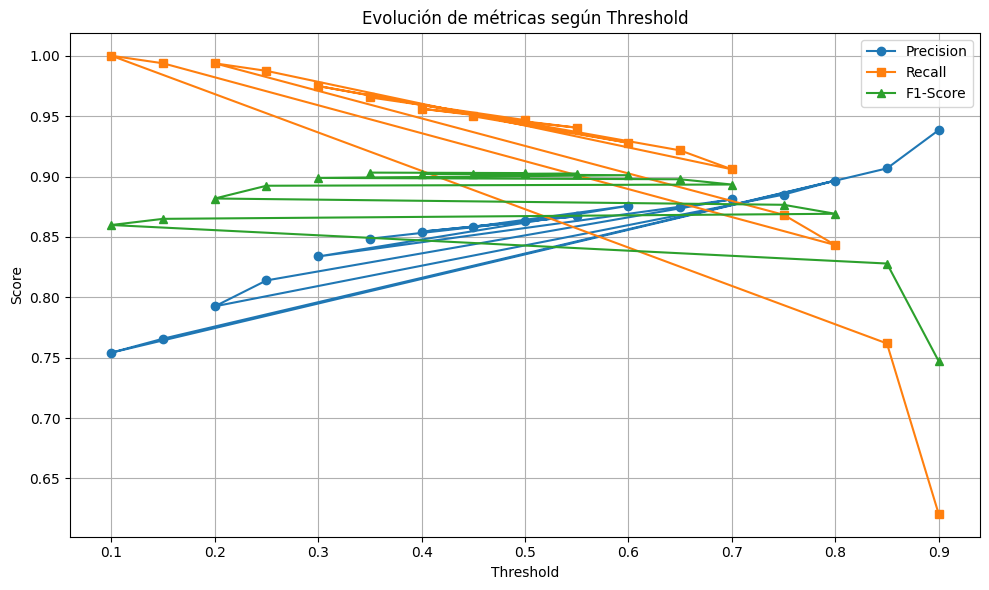

In [273]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from scipy.special import expit  # para convertir logits a probabilidades

def evaluar_metricas_clasicas(y_true, y_proba, threshold=0.5):
    """
    Calcula TP, FP, TN, FN, Precision, Recall y F1 score para un threshold dado.
    """
    y_pred = (y_proba >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)

    return {
        "Threshold": threshold,
        "TP": tp, "FP": fp, "TN": tn, "FN": fn,
        "Precision": precision,
        "Recall": recall,
        "F1": f1
    }

def evaluar_multiples_thresholds(y_true, y_proba, n_pasos=17, plot=True):
    """
    Evalúa precision, recall y F1 para múltiples thresholds.
    Retorna DataFrame ordenado por F1.
    """
    thresholds = np.linspace(0.1, 0.9, n_pasos)
    results = [evaluar_metricas_clasicas(y_true, y_proba, t) for t in thresholds]
    df = pd.DataFrame(results).sort_values(by="F1", ascending=False).reset_index(drop=True)

    print("📊 Mejores thresholds según F1-Score:")
    display(df.head(10))

    if plot:
        plt.figure(figsize=(10, 6))
        plt.plot(metrics_df["Threshold"], metrics_df["Precision"], label="Precision", marker='o')
        plt.plot(metrics_df["Threshold"], metrics_df["Recall"], label="Recall", marker='s')
        plt.plot(metrics_df["Threshold"], metrics_df["F1"], label="F1-Score", marker='^')
        plt.xlabel("Threshold")
        plt.ylabel("Score")
        plt.title("Evolución de métricas según Threshold")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()
    
    return df

logits_val = modelo_final(X_val_tensor[:, feature_idx_list]).detach().cpu().numpy().flatten()
y_proba_val = expit(logits_val)
y_true_val = y_val_tensor.cpu().numpy().flatten()

# Ejecutar evaluación
metrics_df = evaluar_multiples_thresholds(y_true_val, y_proba_val)

In [274]:
import pandas as pd
from scipy.stats import rankdata

# === 1. Selección de columnas para test ===
X_test_selected = X_test[feature_names].copy()
X_test_selected = X_test_selected[[feature_names[i] for i in feature_idx_list]]
X_test_tensor = torch.tensor(X_test_selected.values, dtype=torch.float32).to(device)

# === 2. Obtener logits y aplicar normalización por ranking ===
modelo_final.eval()
with torch.no_grad():
    logits_test = modelo_final(X_test_tensor).cpu().numpy().flatten()
    ranked_preds_test = rankdata(logits_test, method='average') / len(logits_test)

# === 3. Crear submission.csv ===
submission_df = pd.DataFrame({
    "id": test_ids,
    "rainfall": ranked_preds_test
})

submission_df.to_csv("submission.csv", index=False)
print("✅ Archivo submission.csv generado correctamente.")


✅ Archivo submission.csv generado correctamente.


📌 Threshold = 0.65
TP: 292 | FP: 40 | TN: 79 | FN: 27
Precision: 0.8795
Recall:    0.9154
F1-Score:  0.8971


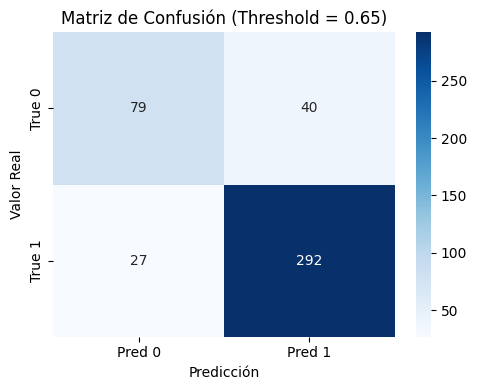

In [275]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

# === 1. Clasificar con threshold = 0.58 ===
threshold_optimo = 0.65
y_pred_058 = (y_proba_val >= threshold_optimo).astype(int)

# === 2. Calcular métricas ===
cm = confusion_matrix(y_true_val, y_pred_058)
tn, fp, fn, tp = cm.ravel()

precision = precision_score(y_true_val, y_pred_058)
recall = recall_score(y_true_val, y_pred_058)
f1 = f1_score(y_true_val, y_pred_058)

# === 3. Mostrar métricas ===
print(f"📌 Threshold = {threshold_optimo}")
print(f"TP: {tp} | FP: {fp} | TN: {tn} | FN: {fn}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")

# === 4. Visualizar matriz de confusión ===
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Pred 0', 'Pred 1'], yticklabels=['True 0', 'True 1'])
plt.title(f"Matriz de Confusión (Threshold = {threshold_optimo})")
plt.ylabel('Valor Real')
plt.xlabel('Predicción')
plt.tight_layout()
plt.show()


# Bloque para comparar tu modelo con el "perfect_submission"

📊 Correlación Spearman: 0.6732
📈 Correlación Pearson:  0.6873

🔍 Casos con mayor diferencia entre tu modelo y el perfecto:


,id,y_pred_mio,y_pred_perfect,abs_diff
4,2194,0.017808,1.000000,0.982192
20,2210,0.049315,1.000000,0.950685
37,2227,0.908219,0.000000,0.908219
45,2235,0.097260,1.000000,0.902740
81,2271,0.884932,0.000000,0.884932
123,2313,0.142466,1.000000,0.857534
64,2254,0.146575,1.000000,0.853425
125,2315,0.168493,1.000000,0.831507
323,2513,0.916438,0.106849,0.809589
97,2287,0.780822,0.000000,0.780822


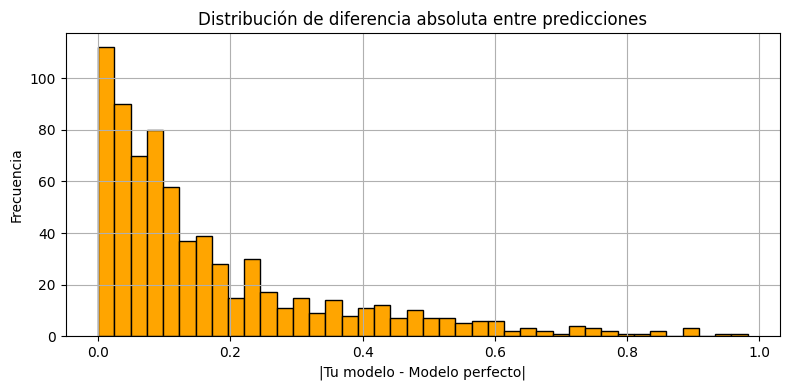

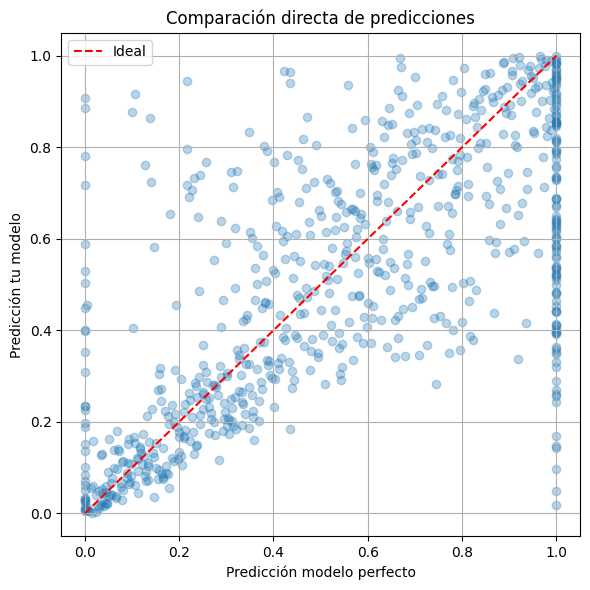

In [286]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import spearmanr, pearsonr

def comparar_vs_perfecto(perfect_csv_path, test_ids, y_pred_mio, plot=True):
    """
    Compara tus predicciones contra el modelo perfecto.
    
    Parámetros:
    - perfect_csv_path: ruta al archivo perfect_submission.csv
    - test_ids: lista o array con los IDs de tus predicciones
    - y_pred_mio: tus predicciones normalizadas o calibradas (ranking o probabilidades)
    - plot: si True, muestra histogramas y gráficos

    Retorna:
    - comparacion_df: DataFrame con ID, predicción tuya, perfecta y diferencia absoluta
    - correlaciones: diccionario con correlaciones Spearman y Pearson
    """

    # 1. Cargar submission perfecta
    perfect_df = pd.read_csv(perfect_csv_path)

    # 2. Armar DataFrame de comparación
    comparacion_df = pd.DataFrame({
        "id": test_ids,
        "y_pred_mio": y_pred_mio
    }).merge(perfect_df, on="id", how="inner")

    comparacion_df = comparacion_df.rename(columns={"rainfall": "y_pred_perfect"})

    # 3. Correlación Spearman
    corr_spearman, _ = spearmanr(comparacion_df["y_pred_mio"], comparacion_df["y_pred_perfect"])

    # 4. Correlación Pearson
    corr_pearson, _ = pearsonr(comparacion_df["y_pred_mio"], comparacion_df["y_pred_perfect"])

    # 5. Diferencia absoluta
    comparacion_df["abs_diff"] = np.abs(comparacion_df["y_pred_mio"] - comparacion_df["y_pred_perfect"])

    # 6. Mostrar resultados
    print(f"📊 Correlación Spearman: {corr_spearman:.4f}")
    print(f"📈 Correlación Pearson:  {corr_pearson:.4f}")
    print("\n🔍 Casos con mayor diferencia entre tu modelo y el perfecto:")
    display(comparacion_df.sort_values("abs_diff", ascending=False).head(10))

    if plot:
        # Histograma de diferencias
        plt.figure(figsize=(8, 4))
        plt.hist(comparacion_df["abs_diff"], bins=40, color="orange", edgecolor="black")
        plt.title("Distribución de diferencia absoluta entre predicciones")
        plt.xlabel("|Tu modelo - Modelo perfecto|")
        plt.ylabel("Frecuencia")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # Scatterplot de comparación
        plt.figure(figsize=(6, 6))
        plt.scatter(comparacion_df["y_pred_perfect"], comparacion_df["y_pred_mio"], alpha=0.3)
        plt.plot([0, 1], [0, 1], 'r--', label='Ideal')
        plt.xlabel("Predicción modelo perfecto")
        plt.ylabel("Predicción tu modelo")
        plt.title("Comparación directa de predicciones")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    return comparacion_df, {
        "spearman": corr_spearman,
        "pearson": corr_pearson
    }

comparacion_df, correlaciones = comparar_vs_perfecto(
    perfect_csv_path="/kaggle/input/perfect-submision/perfect_submission.csv",
    test_ids=test_ids,
    y_pred_mio=ranked_preds_test,  # o blend_test, probs_test_nn, etc.
    plot=True
)


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

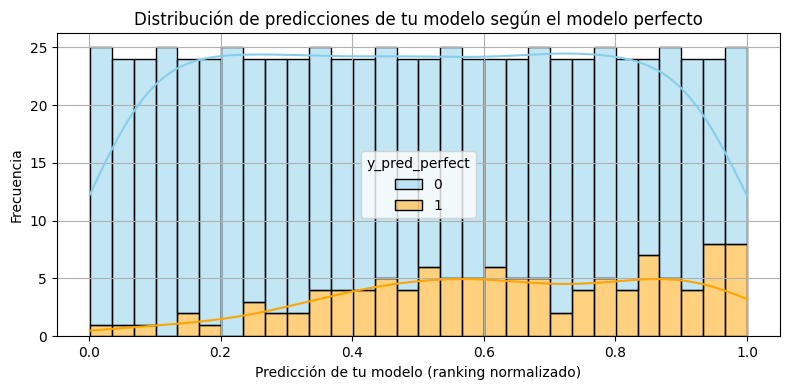

In [288]:
import seaborn as sns
import matplotlib.pyplot as plt

# Asegurar que la columna esté en formato entero para usar como categoría
comparacion_df["y_pred_perfect"] = comparacion_df["y_pred_perfect"].astype(int)

plt.figure(figsize=(8, 4))
sns.histplot(
    data=comparacion_df,
    x="y_pred_mio",
    hue="y_pred_perfect",
    bins=30,
    palette=["skyblue", "orange"],
    kde=True,
    multiple="stack"
)
plt.title("Distribución de predicciones de tu modelo según el modelo perfecto")
plt.xlabel("Predicción de tu modelo (ranking normalizado)")
plt.ylabel("Frecuencia")
plt.grid(True)
plt.tight_layout()
plt.show()



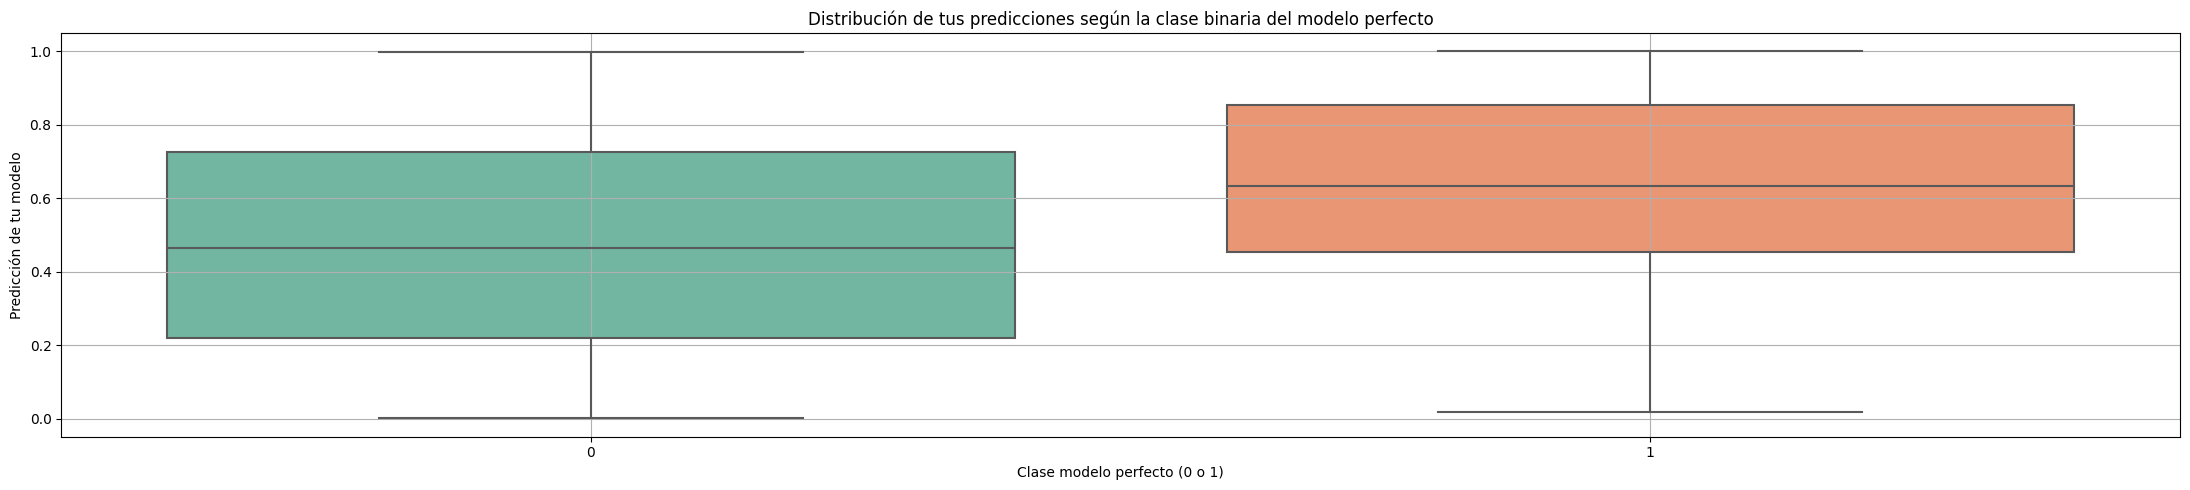

In [278]:
plt.figure(figsize=(22, 5))
sns.boxplot(data=comparacion_df, x="y_pred_perfect", y="y_pred_mio", palette="Set2")
plt.title("Distribución de tus predicciones según la clase binaria del modelo perfecto")
plt.xlabel("Clase modelo perfecto (0 o 1)")
plt.ylabel("Predicción de tu modelo")
plt.grid(True)
plt.tight_layout()
plt.show()


# BLOQUE: Análisis de Features en los Ejemplos con Mayor Error

📊 Features más distintas en los ejemplos con mayor error:


error_alto,Otros,Errores Altos,Diferencia
day_of_year_sin,0.479886,0.773545,0.293658
day_of_year_cos,0.492662,0.599664,0.107003
temperature_rolling_7d,0.657732,0.554879,0.102853
cloud_rolling_14d,0.623018,0.724174,0.101157
sunshine,0.309759,0.208760,0.100999
temperature_rolling_3d,0.663246,0.566570,0.096676
cloud_rolling_7d,0.640758,0.731286,0.090527
temp_lag_1,0.666515,0.576245,0.090270
dew_roll_mean,0.722363,0.641801,0.080562
pressure_rolling_14d,0.442487,0.514946,0.072459


<Figure size 1000x500 with 0 Axes>

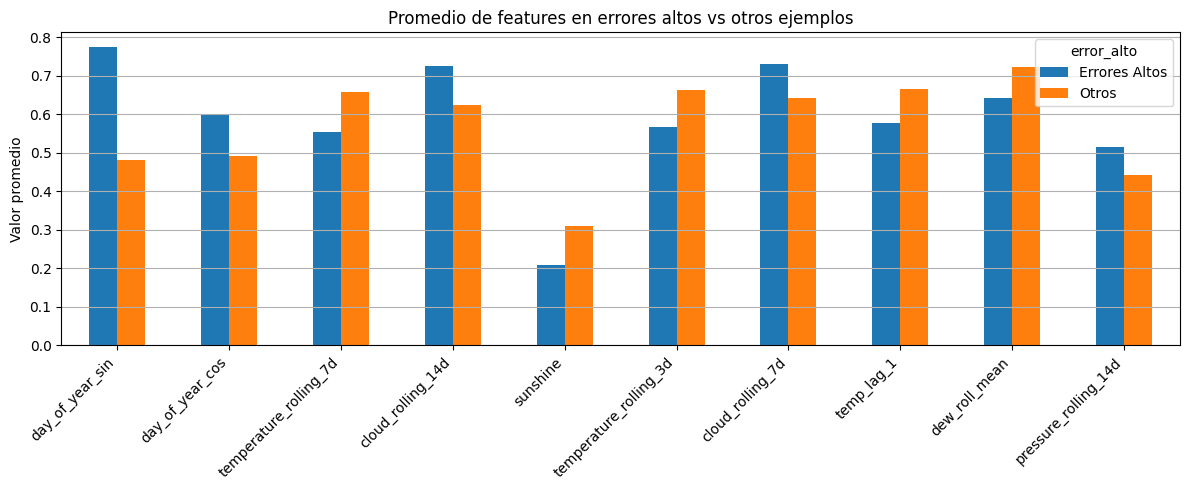

In [279]:
# === 1. Seleccionar top 50 ejemplos con mayor diferencia
errores_altos = comparacion_df.sort_values("abs_diff", ascending=False).head(50)
ids_errores = errores_altos["id"].values

# === 2. Extraer features originales para esos ejemplos
X_test_df = X_test.copy()
X_test_df["id"] = test_ids  # Asegurar que tenga la columna para merge

# Unir con comparacion_df para obtener abs_diff y clase perfecta
X_merged = X_test_df.merge(comparacion_df[["id", "abs_diff", "y_pred_perfect"]], on="id")

# Marcar los errores altos
X_merged["error_alto"] = X_merged["id"].isin(ids_errores).astype(int)

# === 3. Calcular medias de features para errores altos vs bajos
features_to_analyze = X_test.columns  # todas las columnas originales

means_comparison = (
    X_merged
    .groupby("error_alto")[features_to_analyze]
    .mean()
    .T
    .rename(columns={0: "Otros", 1: "Errores Altos"})
)

# Calcular diferencia absoluta entre ambos grupos
means_comparison["Diferencia"] = (means_comparison["Errores Altos"] - means_comparison["Otros"]).abs()
means_comparison_sorted = means_comparison.sort_values("Diferencia", ascending=False)

# === 4. Mostrar tabla con diferencias más grandes
print("📊 Features más distintas en los ejemplos con mayor error:")
display(means_comparison_sorted.head(10))

# === 5. Visualización (barras)
import matplotlib.pyplot as plt

top_n = 10
top_features = means_comparison_sorted.head(top_n)

plt.figure(figsize=(10, 5))
top_features[["Errores Altos", "Otros"]].plot(kind="bar", figsize=(12, 5))
plt.title("Promedio de features en errores altos vs otros ejemplos")
plt.ylabel("Valor promedio")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.tight_layout()
plt.show()
